In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from gplearn.genetic import SymbolicRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
trn = xr.open_dataset('../foo/lores.nc')
tst = xr.open_dataset('../bar/lores.nc')
xfer = xr.open_dataset('../baz/lores.nc')

# Create a library of basis functions which are derivatives of various quantites

In [4]:
def augment_with_derivatives(ds):
    ds['u_x'] = ds.u.differentiate('x')
    ds['u_y'] = ds.u.differentiate('y')
    ds['v_x'] = ds.v.differentiate('x')
    ds['v_y'] = ds.v.differentiate('y')
    ds['u_xx'] = ds.u_x.differentiate('x')
    ds['u_xy'] = ds.u_x.differentiate('y')
    ds['u_yy'] = ds.u_y.differentiate('y')
    ds['v_xx'] = ds.v_x.differentiate('x')
    ds['v_xy'] = ds.v_x.differentiate('y')
    ds['v_yy'] = ds.v_y.differentiate('y')
    ds['q_x'] = ds.q.differentiate('x')
    ds['q_y'] = ds.q.differentiate('y')
    ds['q_xx'] = ds.q_x.differentiate('x')
    ds['q_yy'] = ds.q_y.differentiate('y')
    ds['q_xy'] = ds.q_x.differentiate('y')
    ds['dqdt_x'] = ds.dqdt.differentiate('x')
    ds['dqdt_y'] = ds.dqdt.differentiate('y')
    ds['dqdt_xx'] = ds.dqdt_x.differentiate('x')
    ds['dqdt_xy'] = ds.dqdt_x.differentiate('y')
    ds['dqdt_yy'] = ds.dqdt_y.differentiate('y')
    return ds

for ds in [trn, tst, xfer]:
    augment_with_derivatives(ds)

# Goal will be to predict our two versions of subgrid forcing in the *lower* layer based on our features in both layers

In [5]:
Y1 = trn.isel(lev=1).q_forcing_advection.data.ravel()
Y1_sd = np.std(Y1)
Y1 = Y1 / Y1_sd

Y2 = trn.isel(lev=1).q_forcing_model.data.ravel()
Y2_sd = np.std(Y2)
Y2 = Y2 / Y2_sd

In [124]:
Y1_sd, Y2_sd

(1.06476344e-13, 8.0036685e-14)

In [6]:
feats = ['q','q_x','q_y','q_xx','q_xy','q_yy','dqdt','dqdt_x','dqdt_y','dqdt_xx','dqdt_xy','dqdt_yy','u','v','u_x','u_y','v_x','v_y',
        'u_xx','u_xy','u_yy','v_xx','v_xy','v_yy']
feature_names = [f+'1'for f in feats]+[f+'2'for f in feats]

X = np.array([
    trn.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    trn.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_scale = StandardScaler()
X = X_scale.fit_transform(X)

X.shape

(356352, 48)

In [7]:
Y1_test = tst.isel(lev=1).q_forcing_advection.data.ravel()
Y1_test = Y1_test / Y1_sd

Y2_test = tst.isel(lev=1).q_forcing_model.data.ravel()
Y2_test = Y2_test / Y2_sd

X_test = np.array([
    tst.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    tst.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_test = X_scale.fit_transform(X_test)

X_test.shape

(356352, 48)

In [8]:
Y1_xfer = xfer.isel(lev=1).q_forcing_advection.data.ravel()
Y1_xfer = Y1_xfer / Y1_sd

Y2_xfer = xfer.isel(lev=1).q_forcing_model.data.ravel()
Y2_xfer = Y2_xfer / Y2_sd

X_xfer = np.array([
    xfer.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    xfer.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_xfer = X_scale.fit_transform(X_xfer)

X_xfer.shape

(356352, 48)

# Run linear regression and Lasso baselines (not combining any symbols)

In [9]:
lr1 = LinearRegression()
lr1.fit(X, Y1)
lr1.score(X, Y1), lr1.score(X_test, Y1_test), lr1.score(X_xfer, Y1_xfer)

(0.5110237884681758, 0.5053440973270735, -3.164625728391682)

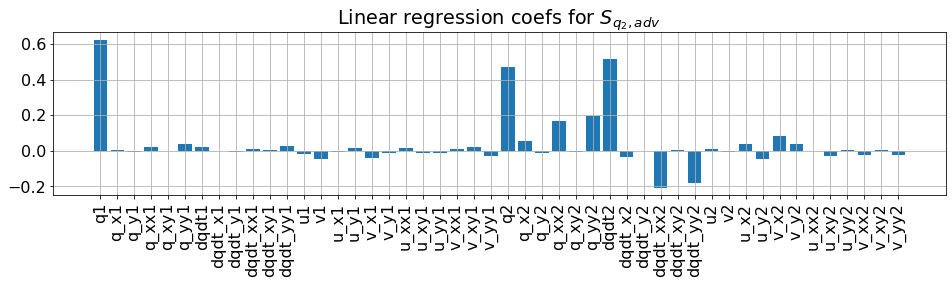

In [29]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), lr1.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Linear regression coefs for $S_{q_2,adv}$")
plt.show()

In [11]:
lr2 = LinearRegression()
lr2.fit(X, Y2)
lr2.score(X, Y2), lr2.score(X_test, Y2_test), lr2.score(X_xfer, Y2_xfer)

(0.11844224354643251, 0.11781882292425794, -0.4791944740940026)

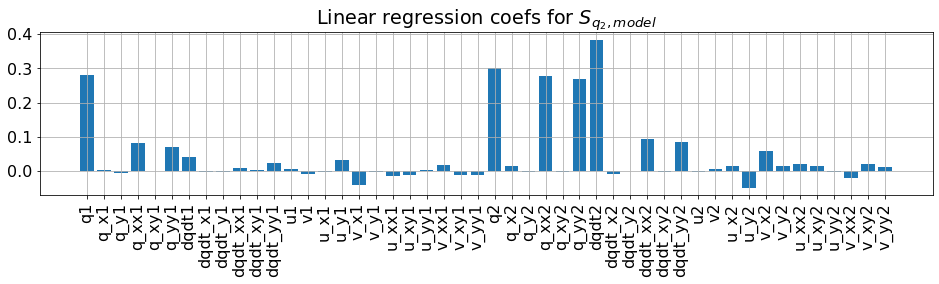

In [30]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), lr2.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Linear regression coefs for $S_{q_2,model}$")
plt.show()

In [13]:
ted1 = Lasso(alpha=0.05)
ted1.fit(X, Y1)
ted1.score(X, Y1), ted1.score(X_test, Y1_test), ted1.score(X_xfer, Y1_xfer)

(0.472994310137381, 0.4659423970231862, -1.243243137222405)

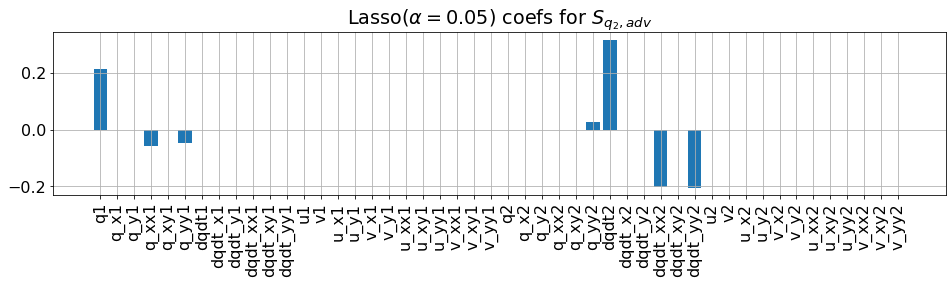

In [31]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), ted1.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Lasso($\\alpha=0.05$) coefs for $S_{q_2,adv}$")
plt.show()

In [15]:
ted2 = Lasso(alpha=0.05)
ted2.fit(X, Y2)
ted2.score(X, Y2), ted2.score(X_test, Y2_test), ted2.score(X_xfer, Y2_xfer)

(0.09777786772407626, 0.09715175502194273, -0.12207130225711493)

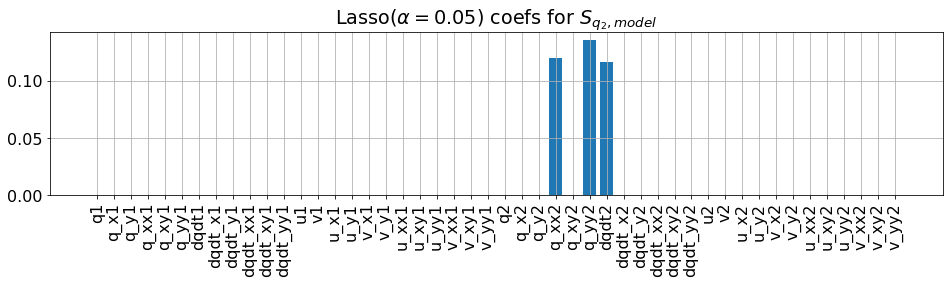

In [32]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), ted2.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Lasso($\\alpha=0.05$) coefs for $S_{q_2,model}$")
plt.show()

# Run neural network baseline (= as well as we can expect symbolic regression to do from the same inputs)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('..')
from models import train

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X.shape[1], 100)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x
    
net = Net()
train(net,X,Y1.reshape(-1,1),num_epochs=20)

Loss after Epoch 1: 0.41593761951194264
Loss after Epoch 2: 0.35488423500571337
Loss after Epoch 3: 0.33469045500608224
Loss after Epoch 4: 0.31942170689246435
Loss after Epoch 5: 0.30846003280489587
Loss after Epoch 6: 0.29691943291965445
Loss after Epoch 7: 0.28702397092149173
Loss after Epoch 8: 0.2821926375450941
Loss after Epoch 9: 0.27607607468293616
Loss after Epoch 10: 0.27084319750128055
Loss after Epoch 11: 0.24420330629633183
Loss after Epoch 12: 0.23929850343713838
Loss after Epoch 13: 0.23753865580235062
Loss after Epoch 14: 0.23629156698743095
Loss after Epoch 15: 0.23539503405122195
Loss after Epoch 16: 0.2319020547592295
Loss after Epoch 17: 0.23142081750998403
Loss after Epoch 18: 0.2308953567254143
Loss after Epoch 19: 0.23087288918583815
Loss after Epoch 20: 0.230854985144273


In [18]:
from sklearn.metrics import r2_score

In [19]:
Y1_pred = net(torch.as_tensor(X)).detach().numpy()
Y1_pred_test = net(torch.as_tensor(X_test)).detach().numpy()
Y1_pred_xfer = net(torch.as_tensor(X_xfer)).detach().numpy()
r2_score(Y1,Y1_pred), r2_score(Y1_test,Y1_pred_test), r2_score(Y1_xfer,Y1_pred_xfer)

(0.7692076471667069, 0.7228550684241517, -7.3651768779377935)

Unsurprisingly, the NN does much better than linear regression at predicting the advection version of subgrid forcing. However, it fails to transfer to the jet configuration. Still, let's investigate what it learned.

In [20]:
import torch.autograd as autograd

X_grad = torch.as_tensor(X).requires_grad_()
Y_grad = net(X_grad)
dy_dx = autograd.grad(Y_grad.sum(), X_grad)[0].detach().numpy()

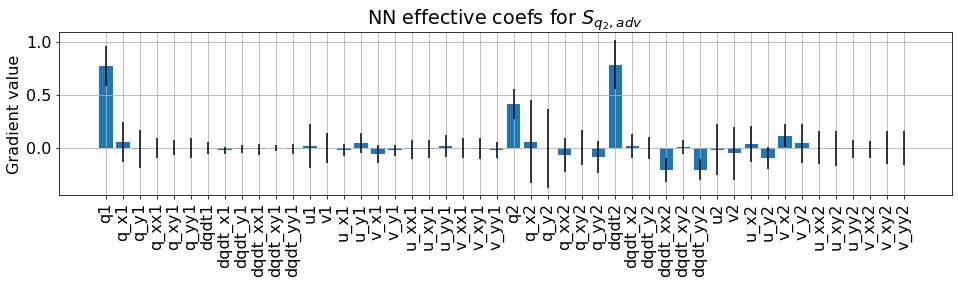

In [33]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), dy_dx.mean(axis=0), yerr=dy_dx.std(axis=0))
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("NN effective coefs for $S_{q_2,adv}$")
plt.ylabel("Gradient value")
plt.show()

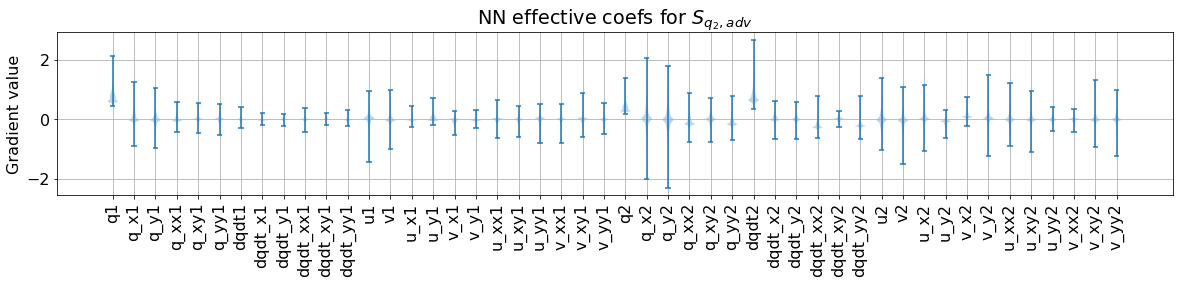

In [22]:
order = np.arange(len(dy_dx))
np.random.shuffle(order)
plt.figure(figsize=(20,3))
plt.violinplot(dy_dx[order[:10000]])
plt.grid()
plt.xticks(np.arange(X.shape[1])+1, feature_names, rotation=90)
plt.title("NN effective coefs for $S_{q_2,adv}$")
plt.ylabel("Gradient value")
plt.show()

In [23]:
important_feats = list(np.argwhere(np.abs(dy_dx).mean(axis=0) > 0.1)[:,0])
print("Important features:")
print([feature_names[i] for i in important_feats])

Important features:
['q1', 'q_x1', 'q_y1', 'u1', 'q2', 'q_x2', 'q_y2', 'q_xx2', 'q_xy2', 'q_yy2', 'dqdt2', 'dqdt_xx2', 'dqdt_yy2', 'u2', 'v2', 'u_x2', 'u_y2', 'v_x2', 'v_y2', 'u_xx2', 'u_xy2', 'v_xy2', 'v_yy2']


For predicting this version of the upper layer's subgrid forcing, it looks like the relevant features are the potential vorticity plus its spatial and time derivatives at both layers, as well as the velocity in the upper layer. It might make sense to initialize symbolic regression with those terms.

But how should symbolic regression combine these terms? Let's investigate with a quick second-order test:

In [24]:
baseline = Y1_pred

dx = 0.01

perturbed_fs = {}

for f in range(len(feature_names)):
    df = np.zeros_like(X)
    df[:,f] = dx
    perturbed_fs[f] = (baseline - net(torch.as_tensor(X + df)).detach().numpy())

In [25]:
doubly_perturbed_fs = {}

for f1 in range(len(feature_names)):
    for f2 in range(len(feature_names)):
        df12 = np.zeros_like(X)
        df12[:,f1] += dx
        df12[:,f2] += dx
        doubly_perturbed_fs[(f1,f2)] = (baseline - net(torch.as_tensor(X + df12)).detach().numpy())

In [26]:
second_diffs = np.array([[
    np.abs(doubly_perturbed_fs[(i,j)] - perturbed_fs[i] - perturbed_fs[j]).mean()
    for i in range(len(feature_names))] for j in range(len(feature_names))
])

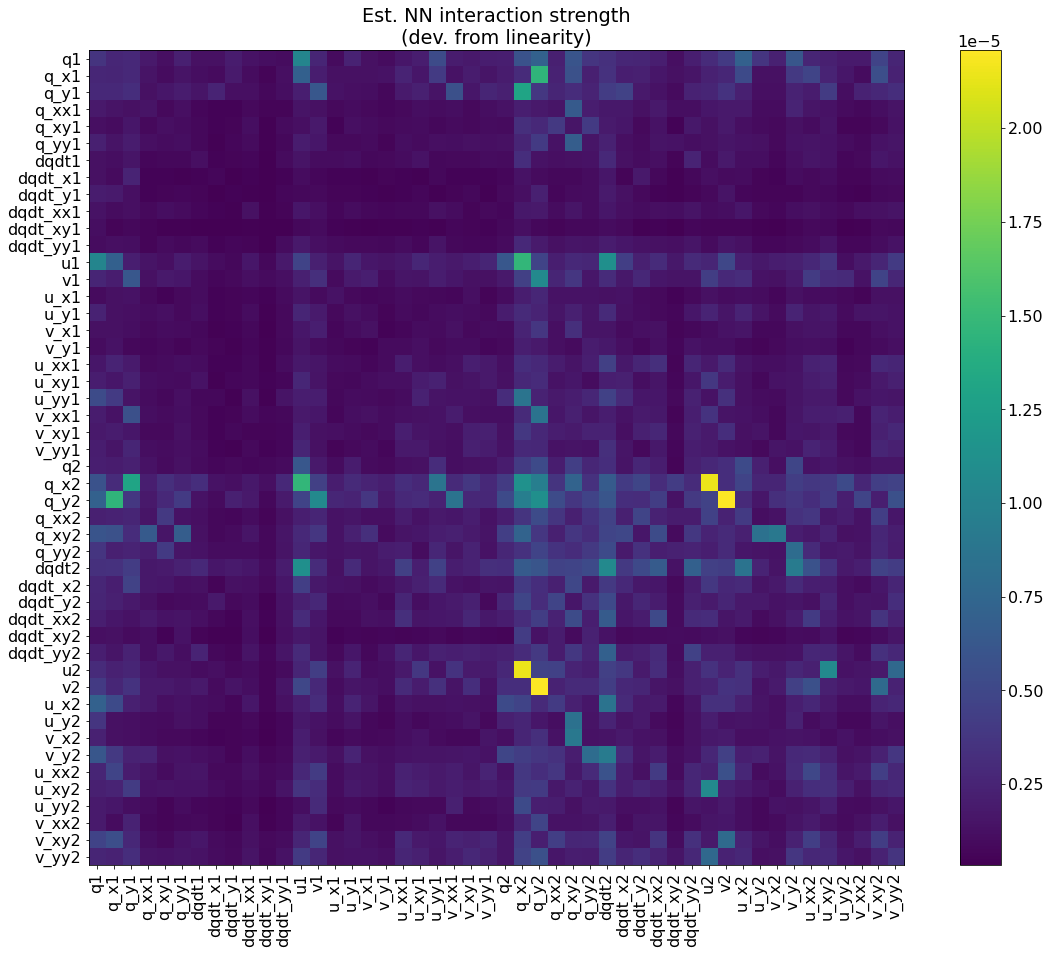

In [27]:
plt.figure(figsize=(20,15))
plt.title("Est. NN interaction strength\n(dev. from linearity)")
plt.imshow(second_diffs)
plt.yticks(range(len(feature_names)), feature_names)
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.colorbar()
plt.show()

In [143]:
interactions = []
for i,j in np.argwhere((second_diffs > 0.000005)):
    if i >= j:
        interactions.append((second_diffs[j,i], feature_names[i], feature_names[j]))
        
print("Important interactions:")
for diff, fi, fj in sorted(interactions, reverse=True):
    print(f"{diff:.6f}: {fi}, {fj}")

Important interactions:
0.000022: v2, q_y2
0.000021: u2, q_x2
0.000015: q_x2, u1
0.000015: q_y2, q_x1
0.000013: q_x2, q_y1
0.000011: q_x2, q_x2
0.000011: q_y2, q_y2
0.000011: dqdt2, u1
0.000011: u_xy2, u2
0.000011: dqdt2, dqdt2
0.000011: q_y2, v1
0.000010: u1, q1
0.000010: q_y2, q_x2
0.000009: v_y2, dqdt2
0.000009: v_x2, q_xy2
0.000009: q_x2, u_yy1
0.000009: q_y2, v_xx1
0.000009: u_x2, dqdt2
0.000008: u_y2, q_xy2
0.000008: v_y2, q_yy2
0.000008: v_xy2, v2
0.000008: v_yy2, u2
0.000007: q_xy2, q_x2
0.000007: u_x2, q1
0.000007: q_y2, q1
0.000007: dqdt_yy2, dqdt2
0.000007: u1, q_x1
0.000007: q_xy2, q_yy1
0.000007: dqdt_xx2, dqdt2
0.000007: dqdt2, q_x2
0.000006: q_xy2, q_xx1
0.000006: v1, q_y1
0.000006: q2, u1
0.000006: v_y2, q1
0.000006: dqdt2, q_y2
0.000006: q_xy2, q1
0.000006: q_x2, q1
0.000006: u_xx2, dqdt2
0.000006: q_xy2, q_x1
0.000006: u_xx2, v2
0.000006: v_xx1, q_y1
0.000006: v_yy2, q_y2
0.000006: v_xy2, q_x1
0.000005: q_xx2, q_y2
0.000005: dqdt_xx2, q_xy2
0.000005: u_yy1, q1
0.00000

A very rudimentary analysis of how the neural network is combining these terms suggests interactions between x/y-velocity and the x/y derivatives of $q$, as well as between the x/y-derivative of $q_1$ and the alternate y/x-derivatives of $q_2$.

In [144]:
def X_with_interactions(ds, scale=None):
    names = [feature_names[f] for f in important_feats if feature_names[f] not in ['q1','q2']]

    X2 = [
        ds[n[:-1]].isel(lev=int(n[-1])-1)
        for n in names
    ]
    
    for _, fi, fj in interactions:
        
        fi_name = fi[:-1]
        fj_name = fj[:-1]
        fi_lev = int(fi[-1])-1
        fj_lev = int(fj[-1])-1
        
        X2.append(ds[fi_name].isel(lev=fi_lev) * ds[fj_name].isel(lev=fj_lev))
        names.append(f"{fi}_times_{fj}")
        
        ### NOTE: tried adding + and - terms, but performance didn't increase
        #X2.append(ds[fi_name].isel(lev=fi_lev) + ds[fj_name].isel(lev=fj_lev))
        #names.append(f"{fi}_plus_{fj}")
        #X2.append(ds[fi_name].isel(lev=fi_lev) - ds[fj_name].isel(lev=fj_lev))
        #names.append(f"{fi}_minus_{fj}")
        
    X2 = np.array([x.data.ravel() for x in X2]).T
    
    if scale is None:
        scale = StandardScaler(with_mean=False)
        scale.fit(X2)
        
    return scale.transform(X2), names, scale

X2, names2, scale2 = X_with_interactions(trn)
X2_test, _, __ = X_with_interactions(tst, scale2)
X2_xfer, _, __ = X_with_interactions(xfer, scale2)

In [145]:
lr1.score(X, Y1), lr1.score(X_test, Y1_test), lr1.score(X_xfer, Y1_xfer)

(0.5110237884681758, 0.5053440973270735, -3.164625728391682)

In [146]:
lr3 = Ridge()
lr3.fit(X2, Y1)
lr3.score(X2, Y1), lr3.score(X2_test, Y1_test), lr3.score(X2_xfer, Y1_xfer)

(0.5301743868950131, 0.5219192343799282, 0.21745230831645335)

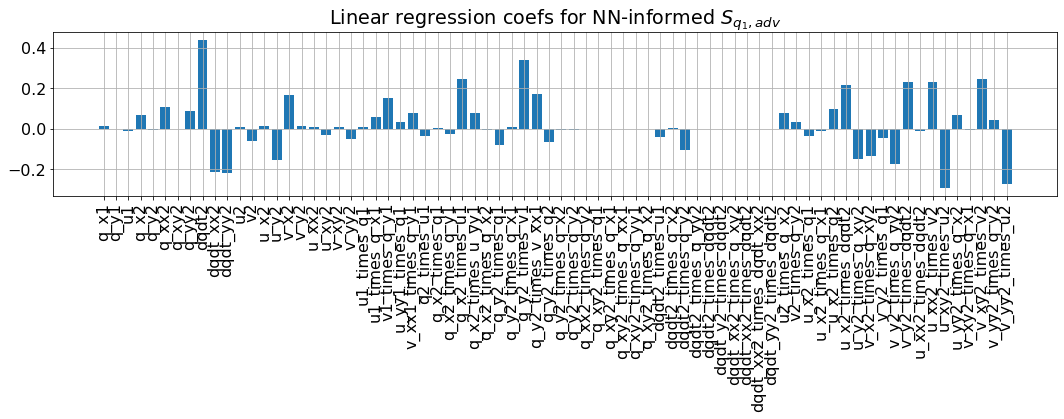

In [147]:
plt.figure(figsize=(18,3))
plt.bar(np.arange(X2.shape[1]), lr3.coef_)
plt.xticks(np.arange(X2.shape[1]), names2, rotation=90)
plt.grid()
plt.title("Linear regression coefs for NN-informed $S_{q_1,adv}$")
plt.show()

In [148]:
lr3 = Lasso(alpha=0.005)
lr3.fit(X2, Y1)
lr3.score(X2, Y1), lr3.score(X2_test, Y1_test), lr3.score(X2_xfer, Y1_xfer)

(0.519497320721793, 0.5116401016202791, 0.2524054340476126)

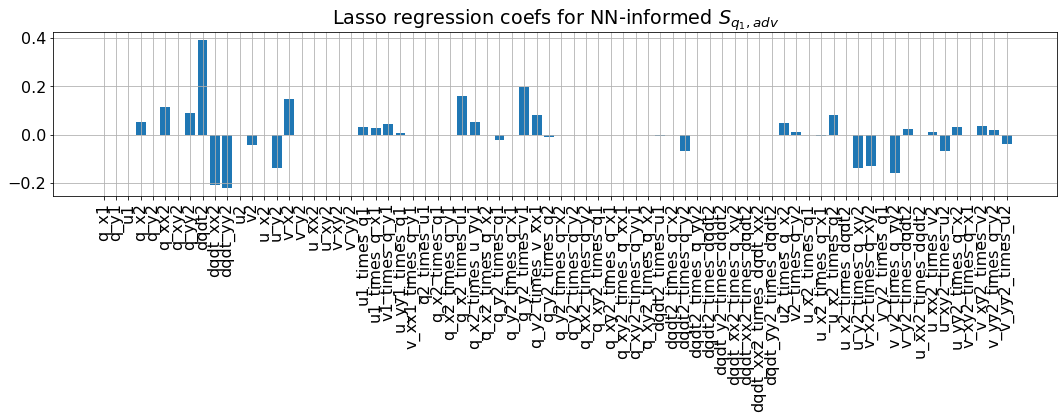

In [149]:
plt.figure(figsize=(18,3))
plt.bar(np.arange(X2.shape[1]), lr3.coef_)
plt.xticks(np.arange(X2.shape[1]), names2, rotation=90)
plt.grid()
plt.title("Lasso regression coefs for NN-informed $S_{q_1,adv}$")
plt.show()


In [150]:
big_lasso = np.argwhere(np.abs(lr3.coef_) > np.abs(lr3.coef_.max()) * 0.05)[:,0]
#big_lasso = np.argwhere(lr3.coef_ > lr3.coef_.max() * 0.05)[:,0]
lr4 = LinearRegression()
lr4.fit(X2[:,big_lasso], Y1)
lr4.score(X2[:,big_lasso], Y1), lr4.score(X2_test[:,big_lasso], Y1_test), lr4.score(X2_xfer[:,big_lasso], Y1_xfer)

(0.5230550399824405, 0.5148099475938555, 0.22866871085411833)

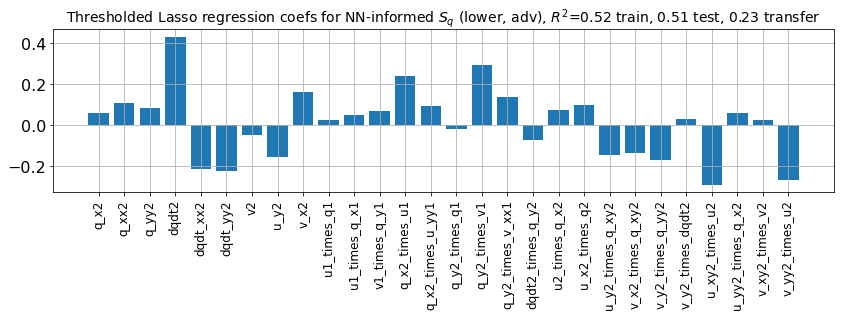

In [151]:
plt.figure(figsize=(14,3))
plt.bar(np.arange(len(big_lasso)), lr4.coef_)
plt.xticks(np.arange(len(big_lasso)), [names2[i] for i in big_lasso], rotation=90, fontsize=12)
plt.grid()
plt.title(f"Thresholded Lasso regression coefs for NN-informed $S_q$ (lower, adv), $R^2$={lr4.score(X2[:,big_lasso], Y1):.2f} train, {lr4.score(X2_test[:,big_lasso], Y1_test):.2f} test, {lr4.score(X2_xfer[:,big_lasso], Y1_xfer):.2f} transfer", fontsize=14)
plt.show()

So, this is pretty cool -- by analyzing our network's gradients and interaction terms, we were able to find a set of linear features that performs better than the initial linear model, and much better than every other model when transferring.

Ok, now let's try to predict our alternate version of subgrid forcing.

In [115]:
net2 = Net()
train(net2,X,Y2.reshape(-1,1),num_epochs=20)

Loss after Epoch 1: 0.8482816215529609
Loss after Epoch 2: 0.8147685813085958
Loss after Epoch 3: 0.8013045123735464
Loss after Epoch 4: 0.7932672749096848
Loss after Epoch 5: 0.7859676361951078
Loss after Epoch 6: 0.7796653636741913
Loss after Epoch 7: 0.7751647615055929
Loss after Epoch 8: 0.7695720865091459
Loss after Epoch 9: 0.7646931673924642
Loss after Epoch 10: 0.7623564270994059
Loss after Epoch 11: 0.7376595266275751
Loss after Epoch 12: 0.7318915599908936
Loss after Epoch 13: 0.7290580745186956
Loss after Epoch 14: 0.7272466385935101
Loss after Epoch 15: 0.7254851606016144
Loss after Epoch 16: 0.7208303128845519
Loss after Epoch 17: 0.7204881457868835
Loss after Epoch 18: 0.7198925218357566
Loss after Epoch 19: 0.719867293939701
Loss after Epoch 20: 0.7198432076899014


In [116]:
Y2_pred = net2(torch.as_tensor(X)).detach().numpy()
Y2_pred_test = net2(torch.as_tensor(X_test)).detach().numpy()
Y2_pred_xfer = net2(torch.as_tensor(X_xfer)).detach().numpy()
print("Train, Test, Transfer")
print(r2_score(Y2,Y2_pred), r2_score(Y2_test,Y2_pred_test), r2_score(Y2_xfer,Y2_pred_xfer))

Train, Test, Transfer
0.2802248569851219 0.23834946968193227 -1.3972465474105435


Interestingly, it looks like it's pretty hard to predict our alternate version of subgrid forcing using this method, even on our training set. For this, we'll probably need alternate features.

# Try nearest neighbors (for Joan)

In [117]:
from sklearn.neighbors import KNeighborsRegressor

knn1 = KNeighborsRegressor(n_neighbors=1)

order = np.arange(len(X))
np.random.shuffle(order)
knn1.fit(X[order[:50000]],Y1[order[:50000]])
knn1.score(X[order[:50000]],Y1[order[:50000]])

1.0

In [118]:
knn1.score(X_test[order[:50000]],Y1_test[order[:50000]])

0.2755515928017236

In [119]:
knn2 = KNeighborsRegressor(n_neighbors=1)
knn2.fit(X[order[:50000]],Y2[order[:50000]])
knn2.score(X[order[:50000]],Y2[order[:50000]])

1.0

In [120]:
knn2.score(X_test[order[:50000]],Y2_test[order[:50000]])

-0.20634224610196195

Nearest neighbors does not work well on the test set :(

# Try symbolic regression with genetic programming to combine terms

In [126]:
reg = SymbolicRegressor(feature_names=feature_names,
                        population_size=5000,
                        generations=20, stopping_criteria=0.01,
                        p_crossover=0.7, p_subtree_mutation=0.1,
                        p_hoist_mutation=0.05, p_point_mutation=0.1,
                        max_samples=0.9, verbose=1,
                        parsimony_coefficient=0.01, random_state=0)
reg.fit(X,Y1)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.71      1.83623e+06        3         0.502353         0.511021     20.69m
   1     3.54          8.55504        5         0.485368         0.483226     14.17m
   2     3.84          1.78295        5         0.484743         0.488855     14.01m
   3     3.06          2.35602        3         0.489569         0.500452     12.21m
   4     2.09          6.03843        3         0.473394         0.473602     13.58m
   5     2.55          2.53488        3          0.46575          0.46876     13.30m
   6     2.99          6.98308        3         0.465473          0.47125     12.48m
   7     3.16          2.38438        3         0.460059         0.454879     11.74m
   8     3.22          1.38835        3          0.45427         0.459532  

SymbolicRegressor(feature_names=['q1', 'q_x1', 'q_y1', 'q_xx1', 'q_xy1',
                                 'q_yy1', 'dqdt1', 'dqdt_x1', 'dqdt_y1',
                                 'dqdt_xx1', 'dqdt_xy1', 'dqdt_yy1', 'u1', 'v1',
                                 'u_x1', 'u_y1', 'v_x1', 'v_y1', 'u_xx1',
                                 'u_xy1', 'u_yy1', 'v_xx1', 'v_xy1', 'v_yy1',
                                 'q2', 'q_x2', 'q_y2', 'q_xx2', 'q_xy2',
                                 'q_yy2', ...],
                  max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [127]:
print(reg._program)

mul(dqdt_yy2, -0.259)


In [128]:
Y_gp = reg.predict(X)
Y_gp2 = reg.predict(X_test)
r2_score(Y_gp,Y1), r2_score(Y_gp2, Y1_test)

(-10.967402336738754, -11.604218397188925)

# Save symbolic regression model

In [152]:
class SymbolicRegressionParameterization(object):
    def __init__(self, linear_model, feature_names, x_scaler, y_sd):
        self.linear_model = linear_model
        self.x_scaler = x_scaler
        self.y_sd = y_sd
        self.feature_names = feature_names
        
    def predict(self, m):
        X = self.input_data(m)
        yhat = self.linear_model.predict(X) * self.y_sd
        return yhat.reshape(64, 64)
        
    def input_data(self, m):
        ds = m.to_dataset()
        import numpy.fft as npfft
        from pyqg.xarray_output import spatial_dims
        ds['dqdt'] = xr.DataArray(
            npfft.irfftn(m.dqhdt,axes=(-2,-1))[np.newaxis],
            coords=[ds.coords[d] for d in spatial_dims]
        )
        
        for f_ in self.feature_names:
            for f in f_.split('_times_'):
                name = f[:-1]
                if name not in ds and '_' in name:
                    orig, diffs = name.split('_')
                    if len(diffs)==1:
                        ds[name] = ds[orig].differentiate(diffs)
                    elif len(diffs)==2:
                        intermed = f"{orig}_{diffs[0]}"
                        if intermed not in ds:
                            ds[intermed] = ds[orig].differentiate(diffs[0])
                        ds[name] = ds[intermed].differentiate(diffs[1])
                    else:
                        assert(False)
                        
        X = []
                        
        for f in self.feature_names:
            if '_times_' in f:
                fi, fj = f.split('_times_')
                fi_name = fi[:-1]
                fj_name = fj[:-1]
                fi_lev = int(fi[-1])-1
                fj_lev = int(fj[-1])-1
                X.append(ds[fi_name].isel(lev=fi_lev) * ds[fj_name].isel(lev=fj_lev))
            else:
                X.append(ds[f[:-1]].isel(lev=int(f[-1])-1))
                
            
        X = np.array([x.data.ravel() for x in X]).T
        
        return self.x_scaler.transform(X)
    
sr_scale = StandardScaler(**scale2.get_params())
for k in ['mean_','var_','scale_']:
    setattr(sr_scale, k, getattr(scale2, k)[big_lasso])

srp = SymbolicRegressionParameterization(
    lr4,
    [names2[i] for i in big_lasso],
    sr_scale,
    Y1_sd)

import pickle
with open('../models/lower_layer_symbolic_regression_parameterization.pkl', 'wb') as f:
    pickle.dump(srp, f)

(1e-23, 0.01)

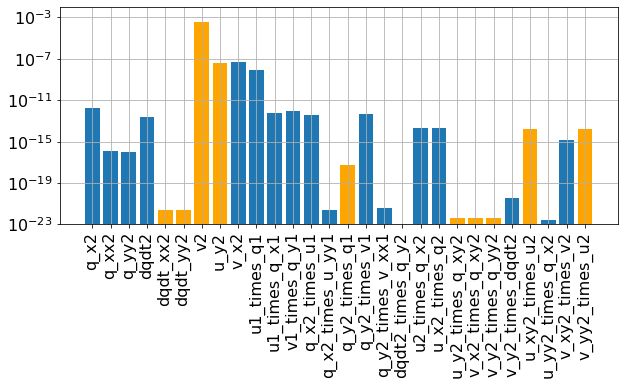

In [153]:
plt.figure(figsize=(10,4))
plt.bar(np.arange(len(srp.linear_model.coef_ )), srp.linear_model.coef_ * srp.x_scaler.scale_)
plt.bar(np.arange(len(srp.linear_model.coef_ )), -srp.linear_model.coef_ * srp.x_scaler.scale_, color='orange')
plt.xticks(np.arange(len(srp.linear_model.coef_ )), srp.feature_names, rotation=90)
plt.grid()
plt.yscale('log')
plt.ylim(1e-23, 1e-2)

In [166]:
def X_with_interactions2(ds, scale=None):
    feats = [
        'dqdt1',
        'dqdt2',
        #'q_x1_minus_q_y1',
        #'q_x2_minus_q_y2',
        'u1_times_q_x1_plus_v1_times_q_y1',
        'u1_times_q_x2_plus_v1_times_q_y2',
        'u2_times_q_x1_plus_v2_times_q_y1',
        'u2_times_q_x2_plus_v2_times_q_y2',
        'u_x1_times_q1_plus_v_y1_times_q1',
        'u_x2_times_q2_plus_v_y2_times_q2',
    ]
    
    ds['q_x'] = ds.q.differentiate('x')
    ds['q_y'] = ds.q.differentiate('y')
    ds['u_x'] = ds.u.differentiate('x')
    ds['v_y'] = ds.u.differentiate('y')
    
    def decompose(f):
        if '_minus_' in f:
            t1, t2 = f.split('_minus_')
            return decompose(t1) - decompose(t2)
        elif '_plus_' in f:
            t1, t2 = f.split('_plus_')
            return decompose(t1) + decompose(t2)
        elif '_times_' in f:
            t1, t2 = f.split('_times_')
            return decompose(t1) * decompose(t2)
        else:
            return ds[f[:-1]].isel(lev=int(f[-1])-1)
        
    X2 = np.array([decompose(f).data.ravel() for f in feats]).T
    
    if scale is None:
        scale = StandardScaler(with_mean=False)
        scale.fit(X2)
        
    return scale.transform(X2), feats, scale 

X3, names3, scale3 = X_with_interactions2(trn)
X3_test, _, __ = X_with_interactions2(tst, scale3)
X3_xfer, _, __ = X_with_interactions2(xfer, scale3)

In [167]:
lr5 = LinearRegression()
lr5.fit(X3, Y1)
lr5.score(X3, Y1), lr5.score(X3_test, Y1_test), lr5.score(X3_xfer, Y1_xfer)

(0.32408334912815506, 0.32311531883105216, 0.3064391329919054)

(1e-23, 0.01)

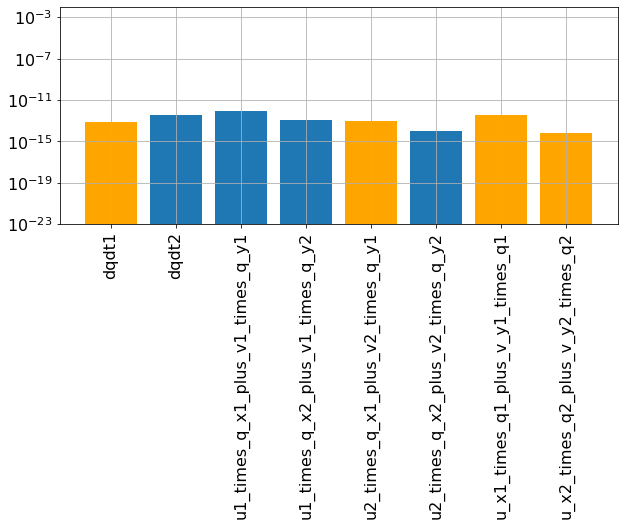

In [168]:
plt.figure(figsize=(10,4))
plt.bar(np.arange(len(lr5.coef_ )), lr5.coef_ * scale3.scale_)
plt.bar(np.arange(len(lr5.coef_ )), -lr5.coef_ * scale3.scale_, color='orange')
plt.xticks(np.arange(len(lr5.coef_ )), names3, rotation=90)
plt.grid()
plt.yscale('log')
plt.ylim(1e-23, 1e-2)